# Machine Learning Notes. The  Baum-Welch algorithm

> 'Using the Baum-Welch algorithm to train hidden Markov models.'

- toc:true
- branch: master
- badges: false
- comments: false
- author: Alexandros Giavaras
- categories: [machine-learning, hidden-markov-model, algorithms]

## <a name="overview"></a> Overview

The third problem associated with Hidden Markov models is that of learning the optimal parameters of the model given a set of sequences. In other words, we want to learn the optimal $\mathbf{B}$ and $\mathbf{A}$ that approximate the given set of sequences. An approach to do this is using the <a href="https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm">Expectation–Maximization algorithm</a> or EM algorithm. In the context of HMM the algorithm bears the name <a href="https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm">Baum–Welch algorithm</a> which is a special instance of the EM algorithm. The following video explains the method.

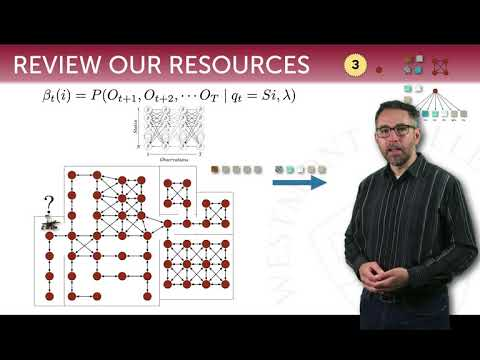

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('JRsdt05pMoI', width=800, height=300)

## <a name="ekf"></a> Baum-Welch algorithm

In the so-called training problem we want to calculate $\lambda$ that maximizes the likelihood of the sample of training sequences $\mathbf{x} = \{O_k\}$ i.e. we want to maximize $P(\mathbf{X}|\lambda)$ [1]. Let's see how this can be done. Let the variable $\xi_t(i,j)$ denote the probability of being at $S_i$ at time $t$ and in $S_j$ at time $t+1$ given $O$ and $\lambda$ i.e.

$$\xi_t(i,j) = P(q_t = S_i, q_{t+1} = S_j | O, \lambda)$$

Note that here $O \in \mathbf{X}$ denotes just one observation sequence. This can be computed as [1]

$$\xi_t(i,j) = \frac{\alpha_t(i)a_{ij}b_j(O_{t+1})\beta_{t+1}(j)}{\sum_{k=1}^{N} \sum_{l=1}^N \alpha_t(k)a_{kl}b_l(O_{t+1})\beta_{t+1}(l)}$$

---
**Remark**

Recall that the probability $P(X,Y|Z)$ can be calculated according to

$$P(X,Y|Z) = P(X|Y,Z)P(Y|Z)$$

from this formula we can write:


$$P(X|Y,Z) = \frac{P(X,Y|Z)}{P(Y|Z)}$$

Thus, 

$$P(q_t = S_i , q_{t+1} = S_j | O, \lambda) = \frac{P(q_t = S_i, q_{t+1} = S_j , O | \lambda)}{P(O|\lambda)}$$

The numerator of the equation avove can be expressed using the forward and backward probabilities.

---

$\alpha_t(i)$ and $\beta_{t+1}(l)$ are simply the <a href="forward_algorithm.html">forward</a> and <a href="backward_algorithm.html">backward</a> variables we saw in the forward and backawrds algorithms respectively. The probability of being in state $S_i$ at time $t$, i.e. $P(q_t=S_i|O,\lambda)$, is given  by marginalizing over the probabilities for all possible next states [1]:

$$\gamma_t(i) = \sum_{j=1}^N \xi_t(i,j)$$

The Baum-Welch algorithm is an EM method. At each iteration we have two steps Expectation, or E-step, followed by a Maximization, or M-step.  At E-step, one  computes $\xi_t(i,j)$ and $\gamma_t(i)$ values given the current $\lambda$. At the M-step we recalculate $\lambda$ given the estimated  $\xi_t(i,j)$ and $\gamma_t(i)$. The E and M steps are alternated until some specified threshold is reached at which point convergence of the algorithm is proclaimed.  

Let's introduce the following two variables [1]

$$z_{i}^{t} = \begin{cases} 1, \text{if}~ q_t = S_i \\ 0, \text{otherwise}\end{cases}$$

and 

$$Z_{i,j}^{t} = \begin{cases} 1, \text{if}~ q_t = S_i ~ \text{and}~ q_{t+1}=S_j \\ 0, \text{otherwise}\end{cases}$$

We estimate these variables in the E-step as, see [1], 

$$E\left[z_{i}^{t}\right] = \gamma_t(i)$$

$$E\left[Z_{ij}^{t}\right] = \xi_t(i,j)$$

At the M-step, given the estimation of $\xi$ and $\gamma$, we calculate the parameters of $\lambda$ as follows, see [1]:

$$\hat{a}_{ij} = \frac{\sum_{t=1}^{T-1} \xi_t(i,j)}{\sum_{t=1}^{T-1} \gamma_t(i)}$$

---

**Remark**

Recall that the transition probability from state $S_i$ to state $S_j$, i.e. $a_{ij}$, is the number of transitions from $S_i$ to $S_j$ divided by the totlal number of transitions from $S_i$ over all sequences:

$$ a_{ij} = \frac{\sum_k \sum_{t=1}^{T-1} I(q_{t}^k = S_i, q_{t+1}^k = S_j)}{\sum_k \sum_{t=1}^{T-1} I(q_{t}^k = S_i )}$$

---

Similarly, we calculate the probability of observing $O_m$ in $S_j$. This is the expected number of times $O_m$ is observed when the system is in $S_j$ over the total number of times the system is in $S_j$ [1]:


$$\hat{b}_j(m) = \frac{\sum_{t=1}^T \gamma_t(j)I(O_t=O_m)}{\sum_{t=1}^T \gamma_t(j)}$$

In the case where we have more than one observation sequences, say we have $K$ of these in total at our disposal, then the parameters are evaluated as averages over all observations in all sequences [1]:


$$\hat{a}_{ij} = \frac{\sum_{k=1}^K \sum_{t=1}^{T-1} \xi_{t}^k(i,j)}{\sum_{k=1}^K \sum_{t=1}^{T-1} \gamma_{t}^k(i)}$$

$$\hat{b}_j(m) = \frac{\sum_{k=1}^K \sum_{t=1}^T \gamma_{t}^k(j)I(O_{t}^{k}=O_m)}{\sum_{k=1}^K \sum_{t=1}^T \gamma_{t}^{k}(j)}$$

$$\hat{\pi}_i = \frac{\sum_{k=1}^K \gamma_{1}^k(i)}{K}$$

### Example

We will continue with the example we used in the Viterbi path notebook. 

In [49]:
import numpy as np

In [50]:
# observation to index
obs_to_idx = {'normal':0, 'cold': 1, 'dizzy':2}

# state to index map
state_to_idx = {'Healthy':0, 'Fever':1}

In [51]:
# HMM parameters
pi = np.array([0.6, 0.4])

# transition probabilities
A = np.array([[0.7, 0.3],
              [0.4, 0.6]])

# emission probabilties
B = np.array([[0.5, 0.4, 0.1],
              [0.1, 0.3, 0.6]])

In [52]:
# now we have a number of observation sequences
# the sequence
X = [['normal', 'cold', 'dizzy'], 
     ['normal', 'cold', 'cold'],
     ['cold', 'cold', 'dizzy'],
     ['normal', 'normal', 'normal']]

In [53]:
def idx_to_obs(idx):
    global obs_to_idx

    for item in obs_to_idx:
        if obs_to_idx[item] == idx:
            return item
    return None

In [54]:
# compute alpha for the given observation
def forward(o, A, B, pi, state_to_idx, obs_to_idx):

    a = np.zeros(shape=(len(o), A.shape[0]))
    for i in range(len(state_to_idx)):
        a[0][i] = pi[i] * B[i][obs_to_idx[o[0]]]

    for t in range(1, len(o)):
        for j in range(A.shape[0]):
            a[t][j] = 0

            # fix j = state_idx and sum over the states
            for i in range(A.shape[0]):
                a[t][j] += a[t - 1][i] * A[i][j]

            a[t][j] *= B[j][obs_to_idx[o[t]]]
    return a

In [55]:
# helper function for backward algorithm
def backward(o, A, B, obs_to_idx):
    beta = np.zeros(shape=(len(o), A.shape[0]))

    # initialize beta
    beta[len(o) - 1] = np.ones(A.shape[0])

    for t in range(len(o) - 2, -1, -1):
        for j in range(A.shape[0]):
            beta[t, j] = (beta[t + 1] * B[:, obs_to_idx[o[t + 1]]]).dot(A[j, :])

    return beta

In [56]:
# compute the denominator for xi calculation
def compute_xi_denom(alpha, A, B, beta, t, idx, idx2):

    denom = 0.0

    for i in range(A.shape[0]):
        for j in range(A.shape[0]):
            denom += alpha[t, i]*A[i, j]*B[j, idx]*beta[idx2, j]
    return denom

In [57]:
# compute xi and gamma related to the observation sequence o
def sequnce_xi_gamma_calculation(o, alpha, beta, A, B, obs_to_idx):

    N = A.shape[0]
    T = len(o)
    xi = [] #[np.zeros((N, N))]*(T-1)
    gamma = np.zeros((T-1, N))

    # calculate xi and gamma for the sequence
    for t in range(T-1):
        local_xi = np.zeros((N, N))
        for i in range(N):
            for j in range(N):
                numerator = alpha[t, i] * A[i, j] * B[j, obs_to_idx[o[t + 1]]] * beta[t + 1, j]
                denom = compute_xi_denom(alpha=alpha, A=A, B=B, beta=beta, t=t, 
                                         idx=obs_to_idx[o[t + 1]], idx2=t+1)
                local_xi[i, j] = numerator / denom

            for k in range(N):
                gamma[t][i] += local_xi[i][k]
        xi.append(local_xi)

    return xi, gamma

In [58]:
# Add additional T'th element in gamma
def get_extra_gammas(alpha, beta, A, B, obs_to_idx, X):

    N = A.shape[0]
    extra_gammas = []

    for k in range(len(X)):

        gamma_k = [0.0 for i in range(N)]

        seq = X[k]
        T = len(seq)
        t = T-2

        # we need to compute the xi
        # for the last observation
        xi_k = np.zeros(shape=(N, N))

        for i in range(N):
            for j in range(N):

                numerator = alpha[t, i] * A[i, j] * B[j, obs_to_idx[seq[t + 1]]] * beta[t + 1, j] 
                denom = compute_xi_denom(alpha=alpha, A=A, B=B, beta=beta, t=t, idx=obs_to_idx[seq[t + 1]], idx2=t+1)
                xi_k[i, j] = numerator / denom

            for kg in range(N):
                gamma_k[i] += xi_k[i][kg]
        extra_gammas.append(gamma_k)

    return extra_gammas

In [59]:
def baum_welch(X, A, B, pi, n_iter, state_to_idx, obs_to_idx):

    print("Number of sequences: ", len(X))
    N = A.shape[0]
    M = B.shape[1]

    print("shape A: ", A.shape)
    print("shape B: ", B.shape)

    #import pdb
    #pdb.set_trace()

    for itr in range(n_iter):

        print("================")
        print("Iteration: ", itr)

        # collect the xis and gammas for
        # evety sequence given in this iteration
        xis = []
        gammas = []
        for seq in range(len(X)):

            o = X[seq]
            T = len(o)

            alpha = forward(o, A, B, pi=pi, state_to_idx=state_to_idx, obs_to_idx=obs_to_idx)
            beta = backward(o, A, B, obs_to_idx=obs_to_idx)

            assert alpha.shape[0] == len(o), "Invalid number of rows for alpha mat: {0} should be {1}".format(alpha.shape[0], len(o))
            assert alpha.shape[1] == N, "Invalid number of columns for alpha mat: {0} should be {1}".format(
                alpha.shape[1], N)
            assert beta.shape[0] == len(o), "Invalid number of rows for beta mat: {0} should be {1}".format(beta.shape[0],
                                                                                                           len(o))
            assert beta.shape[1] == N, "Invalid number of columns for beta mat: {0} should be {1}".format(
                beta.shape[1], N)

            # calculate xi and gamma for this observation sequence
            xi, gamma = sequnce_xi_gamma_calculation(o=o, alpha=alpha,
                                                     beta=beta, A=A, B=B, obs_to_idx=obs_to_idx)


            # xi is an array of length T-1
            assert len(xi) == T - 1, "Invalid size of xi array: {0} should be {1}".format(len(xi), T - 1)

            # for each t we computed xi which is an NxN matrix
            assert xi[0].shape == (N, N), "Invalid xi matrix shape: {0} should be {1}".format(xi[0].shape, (N,N))

            # gamma is a matrix T-1 x N
            assert gamma.shape == (T - 1, N), "Invalid gamma matrix shape: {0} should be {1}".format(gamma.shape, (T - 1, N))

            xis.append(xi)
            gammas.append(gamma)

        assert len(gammas) == len(X), "Invalid number of gammas {0} should be {1}".format(len(gammas), len(X))

        extra_gammas = get_extra_gammas(alpha=alpha, beta=beta, A=A, B=B, obs_to_idx=obs_to_idx, X=X)

        assert len(extra_gammas) == len(X), "Invalid number of extra gammas {0} should be {1}".format(len(extra_gammas), len(X))

      
        # update the transition probabilities
        # the calculations for A have up to T -1
        for i in range(N):

            denom = 0.0
            for k in range(len(X)):
                obs = X[k]
                T = len(obs)

                gamma_k = gammas[k]

                assert gamma_k.shape == (T - 1, N), "Invalid gamma matrix " \
                                                    "shape: {0} should be {1}".format(gamma_k.shape, (T - 1, N))
                for obs_item in range(T - 1):
                    denom += gamma_k[obs_item][i]

            for j in range(A.shape[1]):
                nom = 0.0

                for k in range(len(X)):
                    obs = X[k]
                    xi_k = xis[k]
                    T = len(obs)

                    assert len(xi_k) == T - 1, "Invalid number of "\
                                               "xi_k's: {0} should be {1}".format(len(xi_k), T - 1)

                    for t in range(T - 1):
                        nom += xi_k[t][i, j]

                A[i, j] = nom/denom

        # update the gammas so that we have the
        # final observations
        for k in range(len(gammas)):
            gamma_k = gammas[k]
            gamma_k = np.vstack([gamma_k, extra_gammas[k]])
            gammas[k] = gamma_k

        # in order to calculate B we also need the final
        # bits for gammas
        for i in range(N):

            denom = 0.0
            for k in range(len(X)):

                seq = X[k]
                gamma_k = gammas[k]

                assert len(seq) == gamma_k.shape[0], "Invalid number of Gamma rows {0} should be {1}".format(gamma_k.shape[0], 
                                                                                              len(seq))

                for t in range(len(seq)):
                    denom += gamma_k[t, i]

            for j in range(M):
                nom = 0.0
                for k in range(len(X)):
                    seq = X[k]
                    for t in range(len(seq)):
                        obs = seq[t]

                        if obs == idx_to_obs(j):
                            nom += gammas[k][t, i]

                B[i, j] = nom/denom
                
        # update the pi vector
        for i in range(N):
            
            pi_val = 0.0
            for k in range(len(X)):
                gamma_k = gammas[k]
                pi_val += gamma_k[0][i]
            
            pi[i] = pi_val/(len(X))
        
    return A, B, pi


In [60]:
baum_welch(X=X, A=A, B=B, pi=pi, n_iter=10, state_to_idx=state_to_idx, obs_to_idx=obs_to_idx)

Number of sequences:  4
shape A:  (2, 2)
shape B:  (2, 3)
Iteration:  0
Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
Iteration:  6
Iteration:  7
Iteration:  8
Iteration:  9


(array([[0.60187444, 0.39812556],
        [0.71039728, 0.28960272]]),
 array([[0.50518563, 0.30097656, 0.19383781],
        [0.06660769, 0.87417724, 0.05921507]]),
 array([0.96748237, 0.03251763]))

## <a name="refs"></a> References

1. Ethem Alpaydin, ```Introduction To Machine Learning, Second Edition```, MIT Press.
2. <a href="https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm">Wikipedia-Baum–Welch algorithm</a>.